In [2]:
# CELL TITLE: Install required libraries
# COMMENT: Run once at the top of the notebook. May take a minute.
!pip install --upgrade pip
!pip install transformers datasets torch sentence-transformers rouge-score nltk textstat ipywidgets accelerate huggingface_hub networkx matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.8 MB/s  0:00:00
  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c59d0f47364ed178275b33da69ca92

In [3]:
# Reinstall rouge-score (and confirm)
!pip install --upgrade rouge-score


In [4]:
# Install textstat for readability metrics
!pip install textstat


In [5]:
# CELL TITLE: Core imports & device setup
# COMMENT: Run this cell before any model loads. Downloads NLTK punkt.
import os
import time
import torch
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from math import pi
from IPython.display import display, Markdown, HTML, clear_output
nltk.download('punkt')

# Transformers classes (import once)
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, pipeline

# Sentence Transformers, ROUGE, readability
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
import textstat

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Device: cuda


In [6]:
# CELL TITLE: Clear injected HF secret if present (optional)
# COMMENT: If you previously stored HF_TOKEN as a Colab Secret, Colab injects it automatically.
# If you want to load public models anonymously, unset here and restart kernel if needed.
if "HF_TOKEN" in os.environ:
    print("HF_TOKEN currently in environment. If you want to load public models anonymously, delete it below.")
    # Uncomment next line to remove token from this runtime (temporary)
    # del os.environ["HF_TOKEN"]
    # print("HF_TOKEN removed from environment for this session.")
else:
    print("No HF_TOKEN present in environment.")


No HF_TOKEN present in environment.


In [7]:
# CELL TITLE: Load public models (TinyLlama, Phi, BART) anonymously
# COMMENT: Ensure HF_TOKEN is NOT forcing global auth (see previous cell).
MODELS = {}

# Helper to load causal or seq2seq
def safe_load_causal(repo_id, dtype=None):
    tok = AutoTokenizer.from_pretrained(repo_id)
    mdl = AutoModelForCausalLM.from_pretrained(repo_id, device_map="auto", torch_dtype=dtype) if dtype else AutoModelForCausalLM.from_pretrained(repo_id, device_map="auto")
    return tok, mdl

def safe_load_seq2seq(repo_id, dtype=None):
    tok = AutoTokenizer.from_pretrained(repo_id)
    mdl = AutoModelForSeq2SeqLM.from_pretrained(repo_id, device_map="auto", torch_dtype=dtype) if dtype else AutoModelForSeq2SeqLM.from_pretrained(repo_id, device_map="auto")
    return tok, mdl

# 1) TinyLlama (if public for you) — try load (may require token for some repos)
try:
    print("Loading TinyLlama...")
    t_tok, t_mdl = safe_load_causal("TinyLlama/TinyLlama-1.1B-Chat-v1.0", dtype=torch.bfloat16)
    MODELS['tinyllama'] = {"name":"TinyLlama-1.1B-Chat", "tokenizer": t_tok, "model": t_mdl}
    print("TinyLlama loaded.")
except Exception as e:
    print("TinyLlama load failed (may be gated).", e)

# 2) Phi
try:
    print("Loading Phi...")
    p_tok, p_mdl = safe_load_causal("microsoft/phi-2", dtype=torch.bfloat16)
    MODELS['phi'] = {"name":"microsoft/phi-2", "tokenizer": p_tok, "model": p_mdl}
    print("Phi loaded.")
except Exception as e:
    print("Phi load failed (may be gated).", e)

# 3) BART (seq2seq, public)
try:
    print("Loading BART (facebook/bart-large-cnn)...")
    b_tok, b_mdl = safe_load_seq2seq("facebook/bart-large-cnn")
    MODELS['bart'] = {"name":"facebook/bart-large-cnn", "tokenizer": b_tok, "model": b_mdl}
    print("BART loaded.")
except Exception as e:
    print("BART load failed:", e)

print("Public models currently available:", list(MODELS.keys()))


Loading TinyLlama...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

TinyLlama loaded.
Loading Phi...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Phi loaded.
Loading BART (facebook/bart-large-cnn)...


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BART loaded.
Public models currently available: ['tinyllama', 'phi', 'bart']


In [8]:
# CELL TITLE: Login to Hugging Face (only when loading gated models like Gemma)
# COMMENT: Use interactive login() (recommended) or set the HF_TOKEN env var before running.
from huggingface_hub import login

# Option A: interactive login (recommended)
print("Calling interactive login(); paste your HF token when prompted.")
login()  # follow prompt and paste HF token

# Option B (alternate): uncomment and set env var (less secure)
# os.environ["HF_TOKEN"] = "hf_XXXXXXXXXXXXXXXX"
# login(os.environ["HF_TOKEN"])

print("Logged into Hugging Face (if provided token successfully).")


Calling interactive login(); paste your HF token when prompted.


Logged into Hugging Face (if provided token successfully).


In [17]:
# CELL TITLE: Load Gemma (google/gemma-2b-it) — gated model
# COMMENT: Make sure you accepted the license on the model page before loading.
model_id_gemma = "google/gemma-2b-it"
try:
    HF_TOKEN = os.environ.get("HF_TOKEN", None)
    print("Loading Gemma (this requires license acceptance and token)...")
    g_tok = AutoTokenizer.from_pretrained(model_id_gemma, token=HF_TOKEN)
    g_mdl = AutoModelForCausalLM.from_pretrained(model_id_gemma, torch_dtype=torch.bfloat16, device_map="auto", token=HF_TOKEN)
    MODELS['gemma'] = {"name":"google/gemma-2b-it", "tokenizer": g_tok, "model": g_mdl}
    print("Gemma loaded successfully.")
except Exception as e:
    print("Gemma load failed. Ensure license accepted on HF and token has access.", e)

print("All models in MODELS:", list(MODELS.keys()))


Loading Gemma (this requires license acceptance and token)...


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Gemma loaded successfully.
All models in MODELS: ['tinyllama', 'phi', 'bart', 'gemma']


In [18]:
# CELL TITLE: TextRank extractive summarizer (SentenceTransformer + PageRank)
# COMMENT: Provides summarize_extractive() used later by the UI.
embedder = SentenceTransformer('all-MiniLM-L6-v2')

def textrank_summary(text, top_n=3):
    sentences = nltk.sent_tokenize(text)
    if len(sentences) <= top_n:
        return " ".join(sentences)
    embeddings = embedder.encode(sentences)
    sim_matrix = np.inner(embeddings, embeddings)
    np.fill_diagonal(sim_matrix, 0)
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph)
    ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([s for _, s in ranked[:top_n]])
    return summary

print("TextRank ready.")


TextRank ready.


In [19]:
# CELL TITLE: Summarization & evaluation helpers
# COMMENT: generate_summary handles causal and seq2seq models safely.

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

def generate_summary(model_key, text, max_new_tokens=150, max_length=1024):
    """Generate summary from an abstractive model stored in MODELS."""
    tok = MODELS[model_key]["tokenizer"]
    mdl = MODELS[model_key]["model"]
    # Tokenize
    inputs = tok(text, return_tensors="pt", truncation=True, max_length=max_length).to(mdl.device)
    with torch.no_grad():
        out = mdl.generate(**inputs, max_new_tokens=max_new_tokens)
    return tok.decode(out[0], skip_special_tokens=True)

def summarize_abstractive(text, model_key):
    return generate_summary(model_key, text)

def summarize_extractive(text, model_key):
    # Only TextRank uses model_key 'textrank'
    return textrank_summary(text, top_n=3)

def evaluate_summary(original, summary):
    # ROUGE
    r = scorer.score(original, summary)
    # Semantic similarity (cosine between embeddings)
    s = util.cos_sim(embedder.encode(original), embedder.encode(summary)).item()
    # Readability
    readability = {"flesch": textstat.flesch_reading_ease(summary), "gunning_fog": textstat.gunning_fog(summary)}
    return {"rouge": r, "semantic": s, "readability": readability}

def calculate_metrics(summary, original_text, proc_time):
    m = evaluate_summary(original_text, summary)
    m.update({"Processing_Time": proc_time})
    return m


In [20]:
# CELL TITLE: Visualization helpers (bar chart, radar chart)
# COMMENT: Fixed version — works with flat metrics (rouge1, rouge2, rougeL, semantic).

import numpy as np
import matplotlib.pyplot as plt
from math import pi

# --- Fixed Bar Chart Function ---
def create_bar_charts(df):
    """
    Creates a bar + line combo chart comparing ROUGE-1 and Semantic Similarity.
    Uses flat metric keys ('rouge1', 'semantic') instead of nested dicts.
    """
    fig, ax = plt.subplots(figsize=(7,4))
    models = df['Model'].tolist()

    # Extract values safely (avoid KeyErrors)
    rouge1 = [row.get('rouge1', 0) for _, row in df.iterrows()]
    semantic = [row.get('semantic', 0) for _, row in df.iterrows()]

    # Plot bars and line
    ax.bar(models, rouge1, label='ROUGE-1', alpha=0.7)
    ax.plot(models, semantic, marker='o', label='Semantic Sim', color='black')

    ax.set_ylabel('Score')
    ax.set_title('ROUGE-1 and Semantic Similarity by Model')
    ax.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    return fig


# --- Fixed Radar Chart Function ---
def create_radar_chart(df):
    """
    Creates a radar plot comparing ROUGE-1, ROUGE-2, ROUGE-L, and Semantic scores.
    Works with flat metric keys (rouge1, rouge2, rougeL, semantic).
    """
    labels = ['ROUGE1','ROUGE2','ROUGEL','Semantic']
    num_vars = len(labels)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)

    for _, row in df.iterrows():
        values = [
            row.get('rouge1', 0),
            row.get('rouge2', 0),
            row.get('rougeL', 0),
            row.get('semantic', 0)
        ]
        values += values[:1]
        ax.plot(angles, values, label=row['Model'])
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids([a*180/np.pi for a in angles[:-1]], labels)
    plt.title("Model Comparison (Radar)")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    return fig

print("✅ Visualization helpers (bar & radar) ready!")


✅ Visualization helpers (bar & radar) ready!


In [21]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 🧠 TextMorph Milestone 2 — Summarize with All Models

Textarea(value='', layout=Layout(height='160px', width='100%'), placeholder='Paste text here...')

Button(button_style='success', description='Summarize with All Models', style=ButtonStyle())

Output()

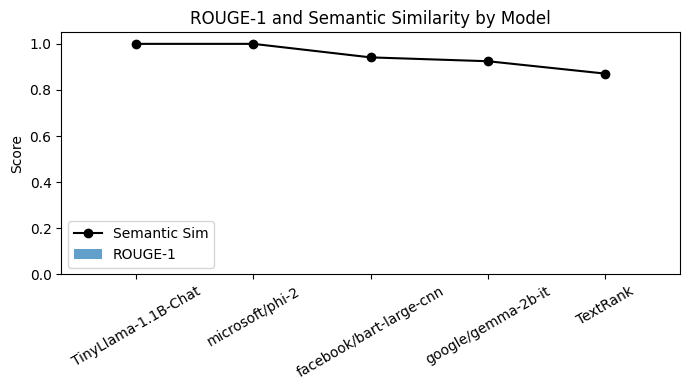

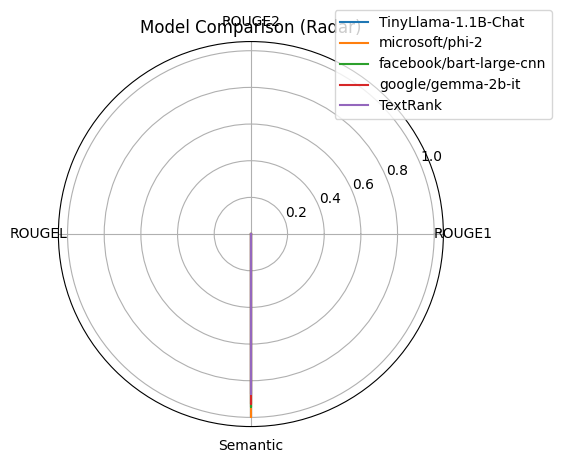

In [22]:
# CELL TITLE: Section A — Summarize with All Models UI
# COMMENT: Single button runs all models (abstractive + extractive) and shows metrics and plots.

import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# UI widgets
text_input_all = widgets.Textarea(placeholder="Paste text here...", layout=widgets.Layout(width='100%', height='160px'))
button_all = widgets.Button(description="Summarize with All Models", button_style='success')
output_all = widgets.Output()
metrics_history_all = []

def on_click_all(b):
    button_all.disabled = True; button_all.description = "Processing..."
    with output_all:
        clear_output()
        text = text_input_all.value
        if not text.strip():
            print("⚠️ Paste some text first.")
            button_all.disabled = False; button_all.description = "Summarize with All Models"; return

        display(Markdown("## Processing: Summaries & Metrics"))
        # Abstractive models in MODELS keys (filter ones actually loaded)
        for key in [k for k in ['tinyllama','phi','bart','gemma'] if k in MODELS]:
            print(f"⏳ Running {MODELS[key]['name']}...")
            start = time.time()
            try:
                summary = summarize_abstractive(text, key)
            except Exception as e:
                summary = f"Generation failed: {e}"
            t = time.time() - start
            display(Markdown(f"### {MODELS[key]['name']}\n{summary}"))
            m = calculate_metrics(summary, text, t); m.update({"Model": MODELS[key]['name'], "Type": "Abstractive", "File":"Pasted Text"})
            metrics_history_all.append(m)

        # TextRank
        tr_summary = textrank_summary(text)
        display(Markdown(f"### TextRank (Extractive)\n{tr_summary}"))
        m = calculate_metrics(tr_summary, text, 0.0); m.update({"Model":"TextRank","Type":"Extractive","File":"Pasted Text"})
        metrics_history_all.append(m)

        # Display table and plots
        df = pd.DataFrame(metrics_history_all)
        display(Markdown("### Metrics Table"))
        display(df)
        display(Markdown("### Bar Chart"))
        display(create_bar_charts(df))
        display(Markdown("### Radar Chart"))
        display(create_radar_chart(df))

    button_all.disabled = False; button_all.description = "Summarize with All Models"

button_all.on_click(on_click_all)

display(Markdown("## 🧠 TextMorph Milestone 2 — Summarize with All Models"))
display(text_input_all, button_all, output_all)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


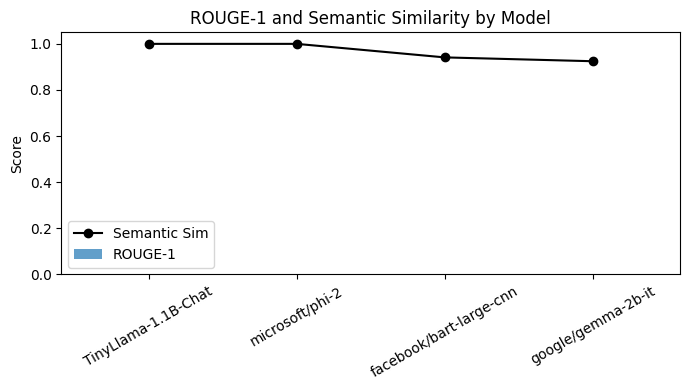

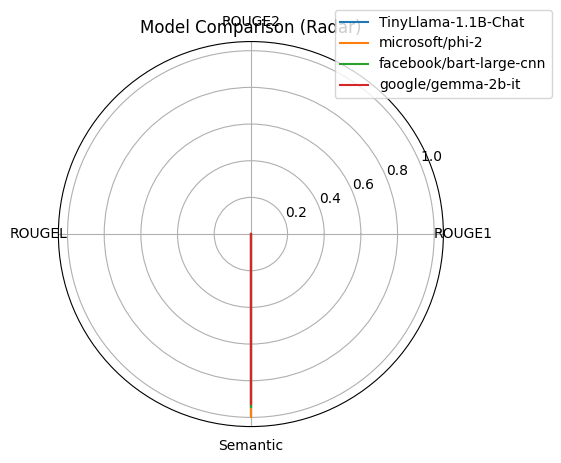

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['semantic'].plot(kind='hist', bins=20, title='semantic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Processing_Time'].plot(kind='hist', bins=20, title='Processing_Time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='semantic', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='semantic', y='Processing_Time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['semantic']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('semantic')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Processing_Time']
  ys = series['semantic']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Processing_Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Processing_Time')
_ = plt.ylabel('semantic')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Processing_Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Processing_Time'}, axis=1)
              .sort_values('Processing_Time', ascending=True))
  xs = counted['Processing_Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Processing_Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Processing_Time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['semantic'].plot(kind='line', figsize=(8, 4), title='semantic')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Processing_Time'].plot(kind='line', figsize=(8, 4), title='Processing_Time')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='semantic', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Processing_Time', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


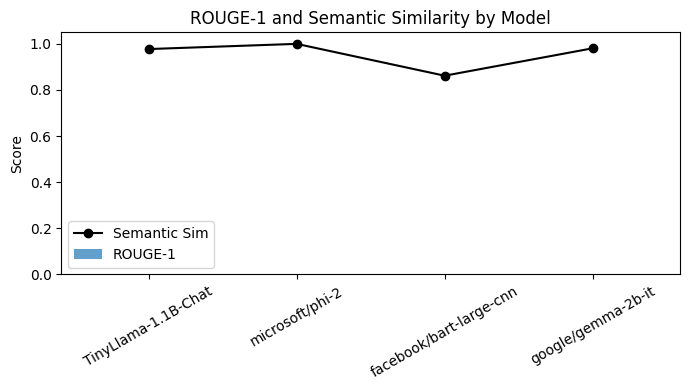

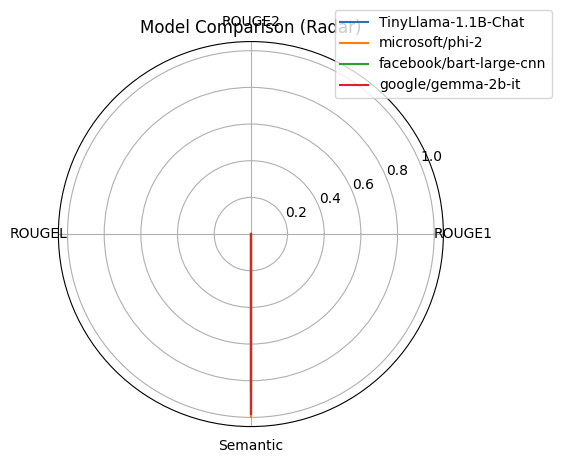

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


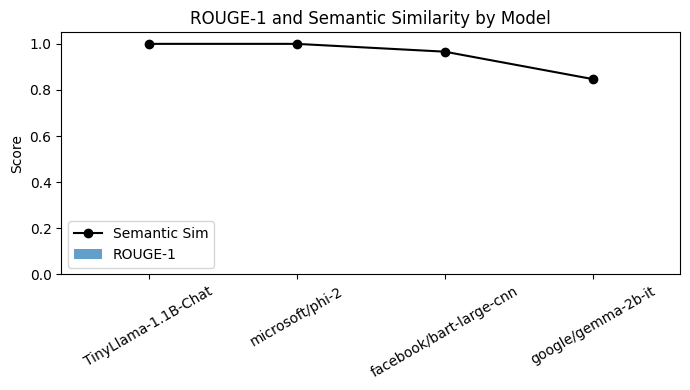

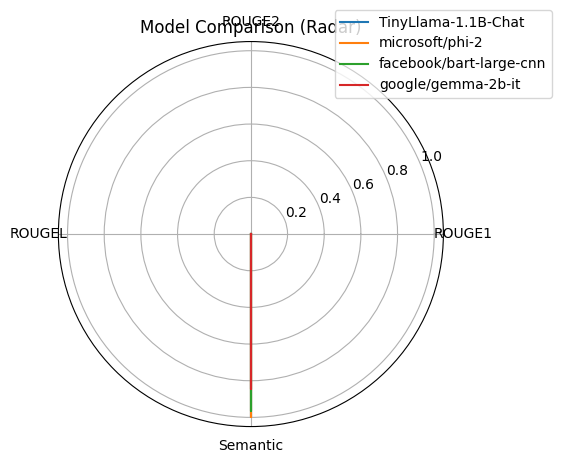

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


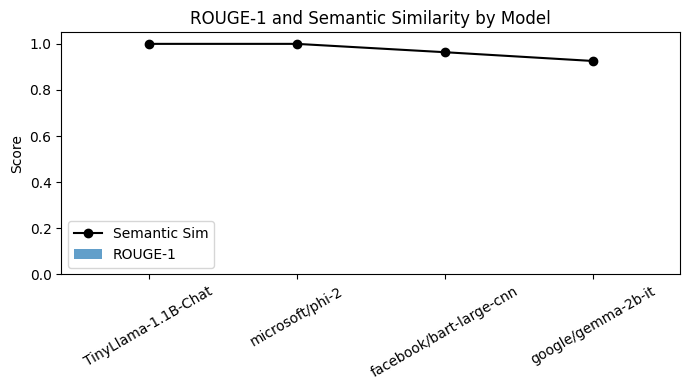

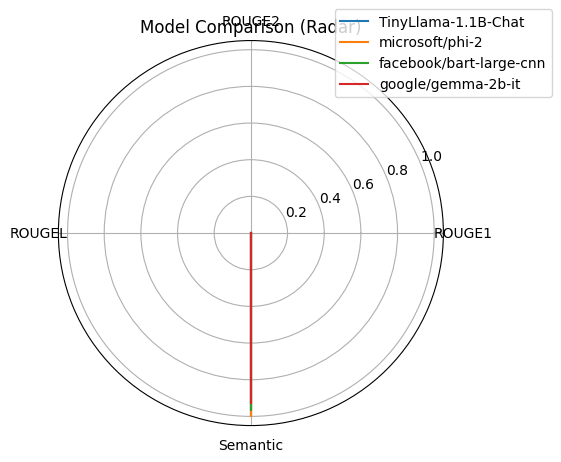

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


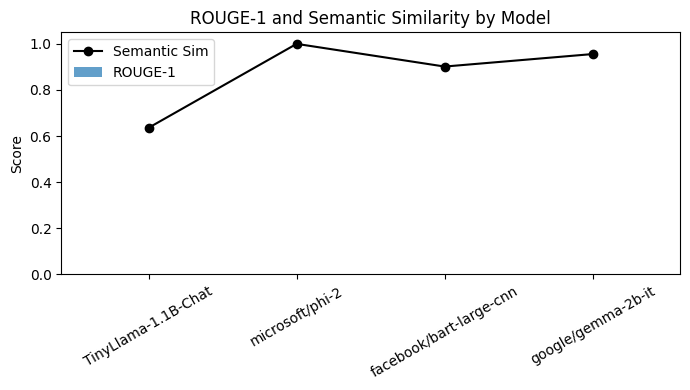

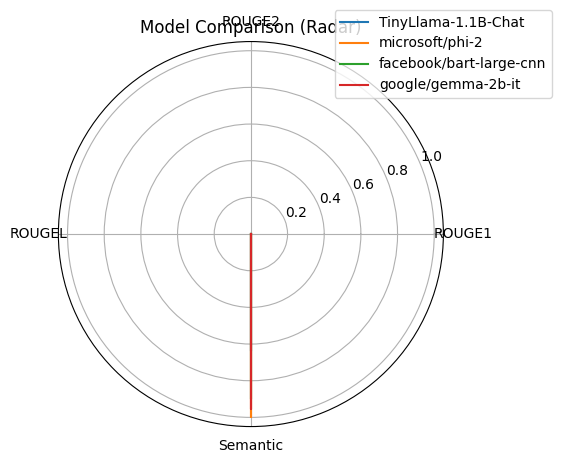

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


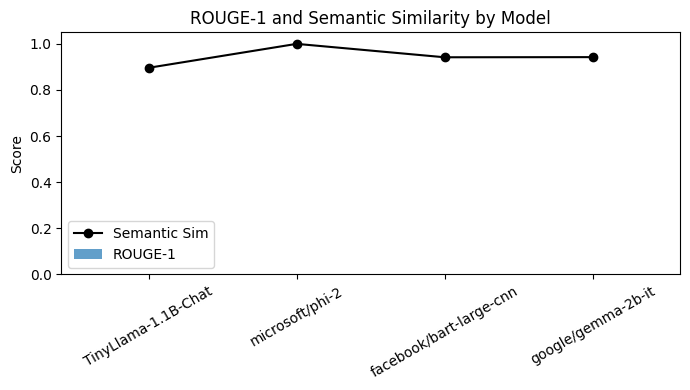

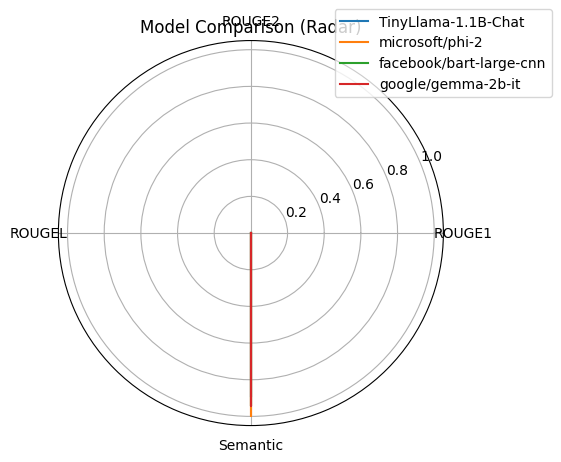

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


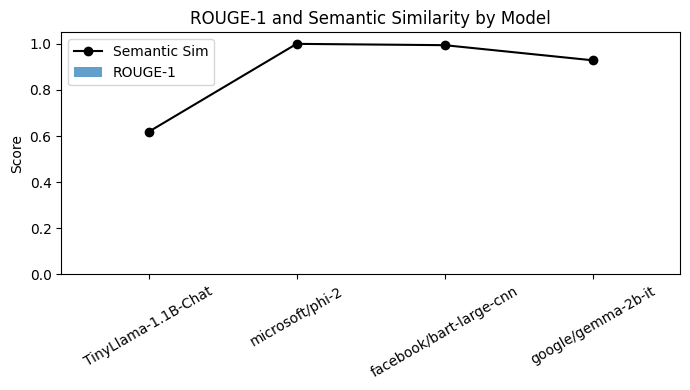

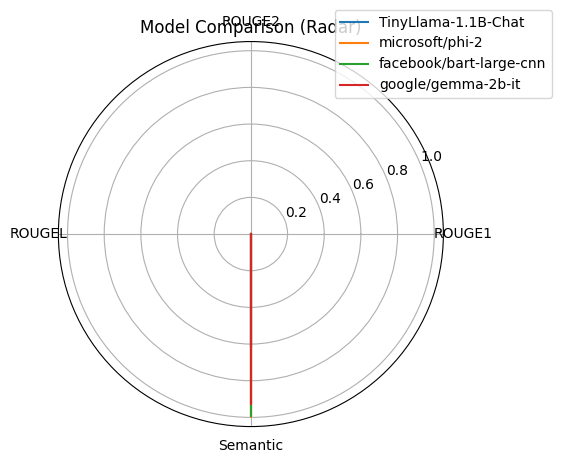

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


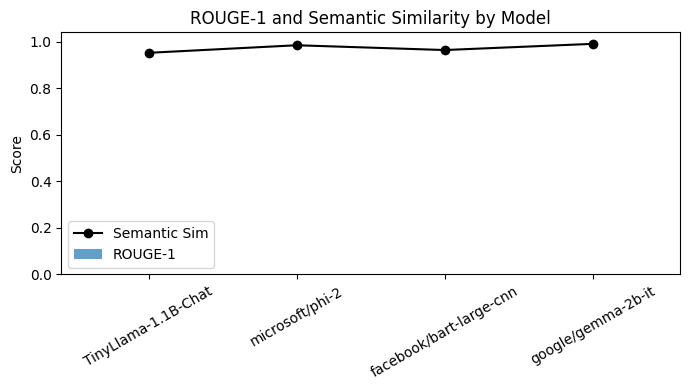

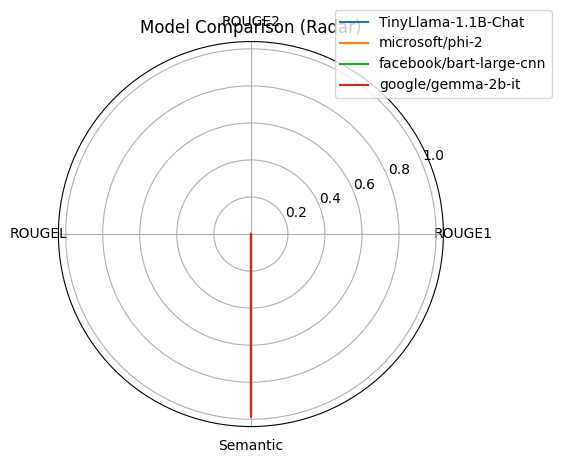

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


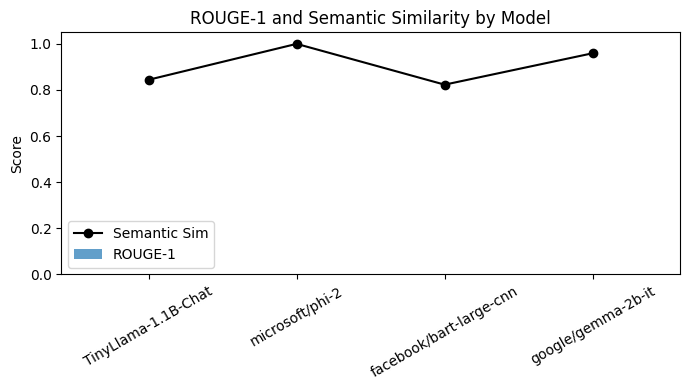

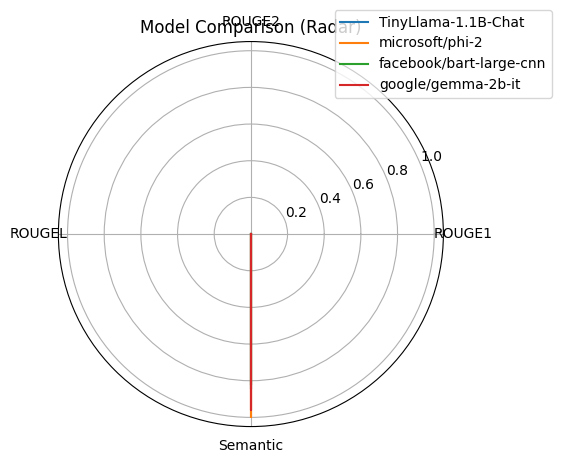

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


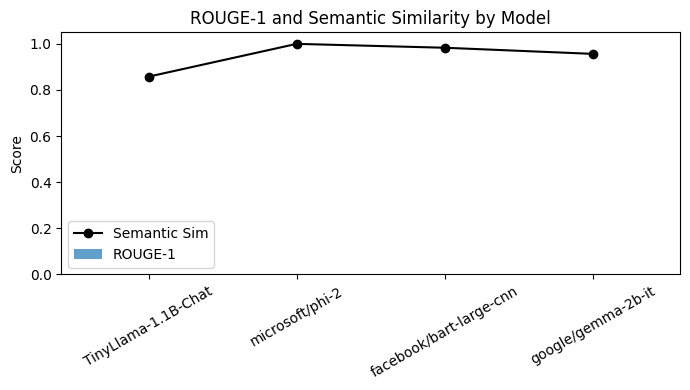

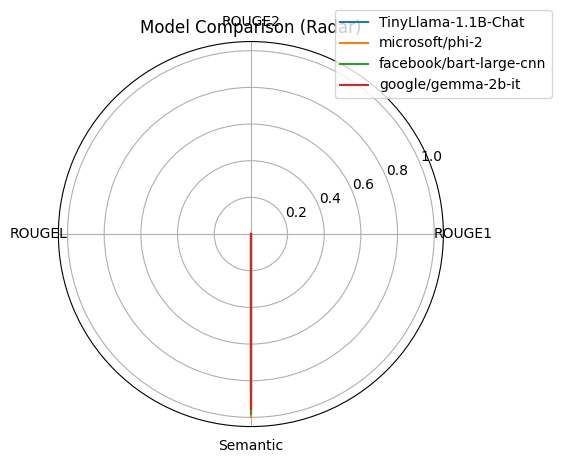

In [23]:
# CELL TITLE: Section B — Summarize with Specific Models UI
# COMMENT: Paste this cell to create the neat two-column UI you provided earlier.

# Predefined model choice maps
abstractive_model_choices = {"TinyLlama": "tinyllama", "Phi-2": "phi", "BART": "bart", "Gemma": "gemma"}
extractive_model_choices = {"TextRank": "textrank"}

# State container
metrics_history_specific = []

# Widgets
header_specific = widgets.HTML("<h2>Section B: Summarize with Specific Models</h2><p>Paste text, choose a summary type, and check the specific models you want to run.</p>")
prompt_input_specific = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_specific = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
model_checkboxes_out = widgets.Output()
checkboxes = {}
generate_button_specific = widgets.Button(description='🚀 Generate Summaries', button_style='primary', icon='cogs')
clear_button_specific = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

summary_output_specific = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()
output_accordion_specific = widgets.Accordion(children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific])
output_accordion_specific.set_title(0, '📊 Metrics Table'); output_accordion_specific.set_title(1, '📈 Bar Charts'); output_accordion_specific.set_title(2, '✨ Radar Plot')

# Helper to populate checkboxes
def update_checkboxes(s_type):
    global checkboxes; checkboxes = {}
    choices = abstractive_model_choices if s_type == 'Abstractive' else extractive_model_choices
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        boxes = []
        for name, key in choices.items():
            # Only show checkbox if model/key is available (or allow TextRank)
            if key == 'textrank' or key in MODELS:
                cb = widgets.Checkbox(value=True, description=name)
                checkboxes[key] = cb
                boxes.append(cb)
        display(widgets.VBox(boxes))

# Generate handler
def on_generate_button_clicked_specific(b):
    generate_button_specific.disabled = True; generate_button_specific.description = "Processing..."
    original_text, s_type = prompt_input_specific.value, summary_type_specific.value
    s_keys = [key for key, cb in checkboxes.items() if cb.value]

    if not original_text.strip() or not s_keys:
        with summary_output_specific:
            summary_output_specific.clear_output(wait=True)
            print("⚠️ Please paste text and check at least one model.")
        generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"; return

    with summary_output_specific:
        summary_output_specific.clear_output(wait=True)
        display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = "TextRank" if model_key == 'textrank' else MODELS[model_key]['name']
        with summary_output_specific:
            print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        try:
            summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" and model_key != 'textrank' else summarize_extractive(original_text, model_key)
        except Exception as e:
            summary = f"Generation failed: {e}"
        proc_time = time.time() - start_time
        with summary_output_specific:
            display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_specific.append(metrics)

    # Prepare dataframe & plots
    df = pd.DataFrame(metrics_history_specific)
    with metrics_table_output_specific:
        metrics_table_output_specific.clear_output(wait=True)
        display(df)
    with bar_plot_output_specific:
        bar_plot_output_specific.clear_output(wait=True)
        display(create_bar_charts(df))
    with radar_plot_output_specific:
        radar_plot_output_specific.clear_output(wait=True)
        display(create_radar_chart(df))

    generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"

# Clear handler
def on_clear_button_clicked_specific(b):
    global metrics_history_specific; metrics_history_specific = []
    summary_output_specific.clear_output(); metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output(); radar_plot_output_specific.clear_output()
    prompt_input_specific.value = ""
    with summary_output_specific:
        print("Outputs cleared.")

# Bind events
generate_button_specific.on_click(on_generate_button_clicked_specific)
clear_button_specific.on_click(on_clear_button_clicked_specific)
summary_type_specific.observe(lambda change: update_checkboxes(change.new), names='value')

# Assemble UI layout
input_controls_specific = widgets.VBox(
    [prompt_input_specific, summary_type_specific, widgets.Label("Select Models:"), model_checkboxes_out, widgets.HBox([generate_button_specific, clear_button_specific])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_specific = widgets.VBox(
    [summary_output_specific, output_accordion_specific],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_specific = widgets.VBox([header_specific, widgets.HBox([input_controls_specific, output_area_specific])])

# Initial checkbox population and display
update_checkboxes('Abstractive')
display(app_specific)


In [24]:
# CELL TITLE: Save all collected metrics and summaries to CSV/JSON files
# COMMENT: Run this anytime after you have run some tests in the UIs.

import json
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Combine all metrics histories (from both UIs)
all_results = []
if 'metrics_history_all' in globals():
    all_results.extend(metrics_history_all)
if 'metrics_history_specific' in globals():
    all_results.extend(metrics_history_specific)

if not all_results:
    print("⚠️ No results yet — run at least one test in the UI before saving.")
else:
    df_results = pd.DataFrame(all_results)

    # Save as CSV
    csv_name = f"TextMorph_Milestone2_Results_{timestamp}.csv"
    df_results.to_csv(csv_name, index=False)

    # Save as JSON
    json_name = f"TextMorph_Milestone2_Results_{timestamp}.json"
    with open(json_name, 'w') as f:
        json.dump(all_results, f, indent=4)

    print(f"✅ Results saved as '{csv_name}' and '{json_name}' in the current Colab directory.")


✅ Results saved as 'TextMorph_Milestone2_Results_20251012_064313.csv' and 'TextMorph_Milestone2_Results_20251012_064313.json' in the current Colab directory.
